Mounted at /content/drive/
replace Flicker8k_Dataset/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/Flicker8k_Dataset/._1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace CrowdFlowerAnnotations.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Number of training samples:  1632
Number of validation samples:  409
Model: "model_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
___________________

ValueError: ignored

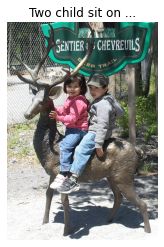

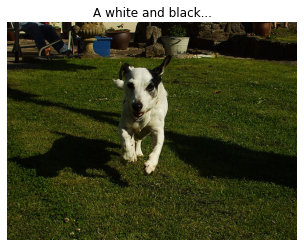

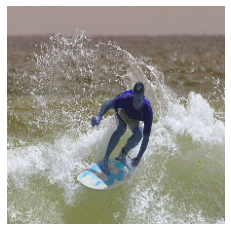

In [43]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   
import tensorflow as tf
import keras
import keras.applications.vgg16
#import keras.model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from sklearn.linear_model import LinearRegression
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
from os import listdir
from pickle import dump
#from keras.applications.vgg16 import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
#from keras.model import model
from array import array
from keras.layers import Input
from keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers.merge import add
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from pickle import load
from nltk.translate.bleu_score import corpus_bleu
from google.colab import files
from google.colab import drive
import datetime
#Data Visualization and augmentation_begin - 3marks
drive.flush_and_unmount()
drive.mount('/content/drive/', force_remount=True)

MY_DRIVE = '/content/drive/My Drive/'
STR_PKL_FILE_NM = 'features.pkl'#'set_0.pkl'
# load : get the data from file
data = pickle.load(open(MY_DRIVE +'set_0.pkl', "rb"))

data = pd.read_pickle(open(MY_DRIVE + 'set_0.pkl', "rb"), compression='infer')
df = pd.DataFrame(data)


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

#!wget -q --no-check-certificate 'https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing' -O image_captioning_dataset.zip
#!unzip -qq image_captioning_dataset.zip
#!rm Flickr8k_Dataset.zip
FIRST_TIME ="Y"
#ensure to type N for next time download
if FIRST_TIME == "Y":
	!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
	!unzip -qq Flickr8k_Dataset.zip
	!rm Flickr8k_Dataset.zip
	!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
	!unzip -qq Flickr8k_text.zip
	!rm Flickr8k_text.zip
#Data Visualization and augmentation_end
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"
MAX_FILE_CNT = 10
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 100

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 5
AUTOTUNE = tf.data.AUTOTUNE
mydataset = list()

def load_captions_data(filename):
    #with open(filename) as caption_file:
        #caption_data = caption_file.readlines()
	caption_mapping = {}
	text_data = []
	text_keys = []
	images_to_skip = set()

	for index, row in df.iterrows():
		txt = row.to_string(header=False, index=False)
		img_name, caption = txt.split('\\t')
		#print(img_name)
		#print(caption)
		#break
		img_name = img_name.split("#")[0].strip()
		#img_name = os.path.join(IMAGES_PATH, img_name.strip())

			# We will remove caption that are either too short to too long
		tokens = caption.strip().split()

		if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
				images_to_skip.add(img_name)
				continue

		if img_name.endswith("jpg") and img_name not in images_to_skip:
				# We will add a start and an end token to each caption
				caption = "<start> " + caption.strip() + " <end>"
				text_data.append(caption)
				text_keys.append(img_name)
				if img_name in caption_mapping:
						caption_mapping[img_name].append(caption)
				else:
						caption_mapping[img_name] = [caption]
	for img_name in images_to_skip:
			if img_name in caption_mapping:
					del caption_mapping[img_name]

	return caption_mapping, text_data,text_keys


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

#Plot at least two samples and their captions (use matplotlib/seaborn/any other library)._BEGIN
def plotimage(ind):
  txt = df.iloc[ind].to_string(header=False, index=False)
  img_name, caption = txt.split('\\t')
  img_name = img_name.split("#")[0]
  img_name = os.path.join(IMAGES_PATH, img_name.strip())
  # reading the image
  testImage = img.imread(img_name)
  # displaying the image
  plt.figure()
  plt.imshow(testImage)
  plt.axis('off')
  plt.title(caption)
  return

plotimage(random.randint(1,len(df.index)))
plotimage(random.randint(1,len(df.index)))
#Plot at least two samples and their captions (use matplotlib/seaborn/any other library)._end

#Bring the train and test data in the required format._BEGIN
# Load the dataset
captions_mapping, text_data, text_keys = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

#Bring the train and test data in the required format._END

#Model Building_BEGIN - 7marks
import sys
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import tempfile

maxlimit = 25000
iind = 1
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

def getRNNModel(vocab_size=1):
	#a. Use	Pretrained	VGG-16	model	trained	on	ImageNet dataset	(available publicly	on	google)	for	image	feature	extraction.
	#b.	Create	3	layered	RNN layer	model	and	other	relevant	layers	for	image	caption	generation.
	#c.	Add	L2	regularization	to	all	the RNN layers.

	# load the model
	model = VGG16()
	# re-structure the model
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	model = add_regularization(model)
 
	top_model = Sequential()
	top_model.add(Flatten(input_shape=model.output_shape[1:]))
	top_model.add(Dense(256, activation='relu'))
	top_model.add(Dropout(0.5))
	top_model.add(Dense(1, activation='sigmoid'))
	top_model.add(Dense(VOCAB_SIZE, activation='sigmoid'))
	#top_model.load_weights(top_model_weights_path)
	model = Model(inputs= model.input, outputs= top_model(model.output))
	print(model.summary())
	opt = Adam(learning_rate=0.01) #SGD(learning_rate=0.01)
	#Model	Compilation	(1 mark)
	model.compile(loss='categorical_crossentropy', optimizer=opt)
	return model

mymodel = getRNNModel()
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
def trainModel():
	#Model	Training	(1 mark)
	trdata = ImageDataGenerator(validation_split=0.98, rescale=1./255)
	traindata = trdata.flow_from_directory(directory=IMAGES_PATH,target_size=(224,224),batch_size=BATCH_SIZE,shuffle=True,seed=42,subset='training', classes=[''])
	tsdata = ImageDataGenerator(validation_split=0.01, rescale=1./255)
	testdata = tsdata.flow_from_directory(directory=IMAGES_PATH,target_size=(224,224),batch_size=BATCH_SIZE,shuffle=True,seed=42,subset='validation', classes=[''])
	#testdata= ImageDataGenerator(rescale=1./255)
	checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
	early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
	hist = mymodel.fit_generator(generator=traindata, validation_data= testdata, epochs=EPOCHS,callbacks=[checkpoint,early])
	print(history)

trainModel()

#BELOW Code for evaluation
# extract features from each photo in the directory
def extract_features(directory):
	model = getRNNModel()
	# extract features from each photo
	features = dict()
	list = os.listdir(directory) # dir is your directory path
	number_files = len(list)
	print("number of files loop")
	print(number_files)
	i = 0
	print("Current Time =", datetime.datetime.now())
	for name in listdir(directory):
		i = i+1
		if i <MAX_FILE_CNT:
			#print('File#' + str(i))
			# load an image from file
			filename = directory + '/' + name
			#print(name)
			image = load_img(filename, target_size=(224, 224))
			# convert the image pixels to a numpy array
			image = img_to_array(image)
			# reshape data for the model
			image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
			# prepare the image for the VGG model
			image = preprocess_input(image)
			# get features
			feature = model.predict(image)#, verbose=0)
			# get image id
			image_id = name.split('.')[0]
			# store feature
			features[image_id] = feature
			mydataset.append(image_id)
			#print('>%s' % name)
	print("Current Time =", datetime.datetime.now())
	return features

# extract features from all images
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
#print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(STR_PKL_FILE_NM, 'wb'))
#print("bits pkl")
#print(pd.read_pickle(open(MY_DRIVE + 'set_0.pkl', "rb"), compression='infer'))
#print("generated pkl")
#print(pd.read_pickle(open(STR_PKL_FILE_NM, "rb"), compression='infer'))

filename = 'Flickr8k_text/Flickr8k.token.txt'
# extract descriptions for images
 
# parse descriptions
#descriptions = captions_mapping
#print('Loaded: %d ' % len(descriptions))
import string

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	I = 0
	for line in doc.split('\n'):
		I = I + 1
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# store the first description for each image
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		# tokenize
		desc = desc.split()
		# convert to lower case
		desc = [word.lower() for word in desc]
		# remove punctuation from each token
		desc = [w.translate(table) for w in desc]
		# remove hanging 's' and 'a'
		desc = [word for word in desc if len(word)>1]
		# store as string
		descriptions[key] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

filename = MY_DRIVE + 'Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	#print("doc:")
	#print(doc)
	#sys.exit()
	I = 0
	# process line by line
	for line in doc.split('\n'):
		I = I + 1
		if I < MAX_FILE_CNT:
			# skip empty lines
			if len(line) < 1:
				continue
			# get the image identifier
			identifier = line.split('.')[0]
			print("key:" + str(identifier))
			dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	#all_features = pickle.load(open(MY_DRIVE +'set_0.pkl', "rb"))
	all_features = pickle.load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# load training dataset (6K)
filename = MY_DRIVE + 'Flickr_8k.trainImages.txt'
#train = set(mydataset) #load_set(filename)
#print('Dataset: %d' % len(train))
# descriptions
#train_descriptions = captions_mapping #load_clean_descriptions('descriptions.txt', train)
#print('Descriptions: train=%d' % len(train_descriptions))
# photo features
#train_features = load_photo_features(MY_DRIVE + 'set_0.pkl', train)
#print('Photos: train=%d' % len(train_features))

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)
 
 # calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
 # define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	#d.Add	one	layer	of	dropout	at	the	appropriate	position	and	give	reasons
	fe1 = Dropout(0.5)(inputs1)
	#e.Choose	the	appropriate	activation	function	for	all	the	layers
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	#e.Choose	the	appropriate	activation	function	for	all	the	layers
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	#Compile	the	model	with	the	appropriate	loss	function
	opt = keras.optimizers.Adam(learning_rate=0.01)
	model.compile(loss='categorical_crossentropy', optimizer=opt)
	# Print	the	model	summary
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

def getimage(key):
	img_name = key.split("/")[1]
	img_name = os.path.join(IMAGES_PATH, img_name.strip())
	# reading the image
	testImage = img.imread(img_name)
	return testImage

#MODEL TRAINING BEGIN
# prepare sequences
filename = MY_DRIVE + 'Flickr_8k.trainImages.txt'
train = set(mydataset) #load_set(filename)
print('Dataset: %d' % len(train))
train_features = load_photo_features(STR_PKL_FILE_NM, train)

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print("train_descriptions")
# determine the maximum sequence length
#print(train_descriptions)
max_length = max_length(train_descriptions)
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1

#print('Description Length: %d' % max_length)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
#sys.exit()
# dev dataset

# load test set
filename = MY_DRIVE + 'Flickr_8k.devImages.txt'
test = set(mydataset) #load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
test_features = load_photo_features(STR_PKL_FILE_NM, test)

# prepare sequences
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

#Model	Compilation _BEGIN
# define the model
mstemmodel = define_model(vocab_size, max_length)
#Model	Compilation _END

# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
#model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))
#model.fit(X1train, ytrain, epochs=20, verbose=2, callbacks=[checkpoint], validation_data=(X1test, ytest))
#MODEL TRAINING END

#	Model	Evaluation_BEGIN
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = np.argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

from keras import models 
# load the model
#print('Input model name:')
#filename = input()
#filename = 'model-ep002-loss3.245-val_loss3.612.h5'
#model = models.load_model(filename)
# evaluate model
#evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
#	Model	Evaluation_END

#sys.exit()
from PIL import Image
import cv2
import requests
from urllib.request import urlopen
from keras.applications.vgg16 import decode_predictions

def readimgaecv2():
	image_url = 'https://tensorflow.org/images/surf.jpg'
	# Read the image using imread function
	resp = urlopen(image_url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	# let's downscale the image using new  width and height
	down_width = 300
	down_height = 200
	down_points = (down_width, down_height)
	resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
	# let's upscale the image using new  width and height
	up_width = 600
	up_height = 400
	up_points = (up_width, up_height)
	resized_up = cv2.resize(image, up_points, interpolation= cv2.INTER_LINEAR)
	# Display images
	cv2.imshow('Resized Down by defining height and width', resized_down)
	cv2.waitKey()
	cv2.imshow('Resized Up image by defining height and width', resized_up)
	cv2.waitKey()
	#press any key to close the windows
	cv2.destroyAllWindows()
	sys.exit()

def resizeimage():
	image_url = 'https://tensorflow.org/images/surf.jpg'
	# Read the image using imread function
	resp = urlopen(image_url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	# let's downscale the image using new  width and height
	down_width = 224
	down_height = 224
	down_points = (down_width, down_height)
	resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
	return resized_down

model2 = VGG16()

def evaluaterandomimage(photo,tokenizer,max_length):
	in_text = 'startseq'
	sequence = tokenizer.texts_to_sequences([in_text])[0]
	# pad input
	sequence = pad_sequences([sequence], maxlen=max_length)
	yhat = mymodel.predict(photo, verbose=0)
	print("RNN Model prediction:" + str(yhat))
	#yhat2 = mstemmodel.predict([photo,sequence], verbose=0)	
	#label = decode_predictions(yhat2)
	#print("Label:" + str(label))
	#label = label[0][0]
	#print('Image prediction: %s (%.2f%%)' % (label[1], label[2]*100))
 
#image_url = 'https://tensorflow.org/images/surf.jpg'
#img1 = Image.open(requests.get(image_url, stream=True).raw)
new_image = resizeimage()
#image.show()
#image_extension = image_url[-4:]
#image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
#image = load_img(image_path, target_size=(224, 224))
#testImage = img.imread(img1)
plt.figure()
plt.imshow(new_image)
plt.axis('off')
image = img_to_array(new_image)
image = preprocess_input(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
evaluaterandomimage(image,tokenizer, max_length)